In [9]:
# inspecting the quality of the IF in higher dimensions.
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [10]:
# function definitions.
def simulate_gaussian_data(n, p, noise_std=1.0):
    """
    Simulate multivariate Gaussian dataset and a response vector 
    according to a standard Gaussian linear model.
    """
    X = np.random.randn(n,p) # X ~ MVN(0, I_p)
    # true_coefficients = np.random.randn(p) # coeff ~ No(0, 1)
    true_coefficients = np.random.rand(p) * 2 - 1 # coeff ~ unif(-1, 1)
    y = X @ true_coefficients + np.random.randn(n) # e ~ N(0, noise_std^2)
    return X, y, true_coefficients

def compute_influence_function_old(X, y, index): # non-vectorized version.
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    index (int): index of the dropped point.
    Output (Array): [p]; the influence function approximation for the point at index.
    """
    # Fit the model to the full dataset
    model1 = LinearRegression(fit_intercept=False)
    model1.fit(X, y)
    
    # Coefficients from the full model
    beta_full = model1.coef_
    
    # Compute the gradient of the loss function w.r.t the parameters
    residuals = y - model1.predict(X)
    gradient = X[index] * residuals[index]
    hessian = np.linalg.inv(X.T @ X)

    # Influence function approximation to dropping a data point.
    return beta_full - (hessian @ gradient)

def compute_influence_function(X, y, model): # vectorized version.
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    Output (Array): [n, p]; the influence function approximation for each point in the dataset.
    """
    # Coefficients from the full model
    beta_full = model.coef_
    # Compute the hession*gradient of the loss function w.r.t \theta.
    residuals = y - model.predict(X)
    XtX = X.T @ X # [P, P]
    XtXinvX = np.linalg.solve(XtX, X.T)  # [P, N]
    XtXinvX * residuals.T # [P, N]
    # Influence function approximation to dropping a data point.
    beta_full = beta_full[:, np.newaxis]
    if_approx = beta_full - (XtXinvX * residuals.T)
    return if_approx.T

def compute_dfbeta_old(X, y, index): # non-vectorized version.
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    index (int): index of the dropped point.
    Output (Array): [p]; the refit after dropping the point at position index.
    """
    # Fit the model to the full dataset
    model1 = LinearRegression(fit_intercept=False)
    model1.fit(X, y)
    
    # Coefficients from the full model
    beta_full = model1.coef_
    
    # Compute the gradient of the loss function w.r.t the parameters
    residuals = y - model1.predict(X)
    gradient = X[index] * residuals[index]
    hessian = np.linalg.inv(X.T @ X)
    leverage = X[index] @ np.linalg.inv(X.T @ X) @ X[index]
    change = (hessian @ gradient) / (1 - leverage)

    # Influence function approximation to dropping a data point.
    return beta_full - change

def compute_dfbeta(X, y, model): # vectorized version.
    '''
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    index (int): index of the dropped point.
    Output (Array): [n, p]; the refits for all n data points.
    '''
    # Coefficients from the full model
    beta_full = model.coef_
    # Compute the hession*gradient of the loss function w.r.t \theta.
    residuals = y - model.predict(X)
    leverage_mat = X @ (np.linalg.inv(X.T @ X)) @ X.T
    
    # adjust the leverage score if it is equal to 1, to avoid division by zero.
    diag_values = np.diag(leverage_mat)
    diag_leverage = np.diag(1 / (1 - diag_values)) # 1/(1-h_ii)
    diag_leverage @ residuals # [N, 1]
    
    XtX = X.T @ X # [P, P]
    XtXinvX = np.linalg.solve(XtX, X.T)  # [P, N]
    # XtXinvX * (diag_leverage @ residuals).T # [P, N]
    # Influence function approximation to dropping a data point.
    beta_full = beta_full[:, np.newaxis]
    refit_approx = beta_full - (XtXinvX * (diag_leverage @ residuals).T)
    return refit_approx.T

def compute_IF_and_refits_smw(X, y):
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    Output (Array): 
    - [n, p]; the influence function approximation for each dropped point.
    - [n, p]; the refit coefficients for each dropped point.
    - [p]; the coefficients from the model fit to full data.
    """
    n = X.shape[0]
    p = X.shape[1]

    model_full = LinearRegression(fit_intercept=False)
    model_full_fit = model_full.fit(X, y)
    model_full_coef = model_full_fit.coef_

    # Compute the eigenvalues of X^T * X
    XtX = np.dot(X.T, X)
    eigenvalues_XtX = np.linalg.eigvals(XtX)

    influence_functions = compute_influence_function(X, y, model_full)
    refit_coefficients = compute_dfbeta(X, y, model_full)

    return influence_functions, refit_coefficients, model_full_coef, eigenvalues_XtX

In [11]:
# unit testing. dfbeta (non-broadcasted version) implemented correctly.
n=2
p=5
testX, testy, testcoeff = simulate_gaussian_data(n, p, noise_std=1.0)

for index in range(n):
    dfbeta = compute_dfbeta_old(testX, testy, index)
    print("dfbeta: ", dfbeta)
    # refit the model without the ith data point.
    deleted_i_X = np.delete(testX, index, axis=0)
    print(f'new dimension of X: {deleted_i_X.shape}')
    deleted_i_y = np.delete(testy, index)
    model_d = LinearRegression(fit_intercept=False)
    model_d.fit(deleted_i_X, deleted_i_y)
    model_d.coef_
    print("refit coefficients: ", model_d.coef_)

# np.allclose()

dfbeta:  [-0.27224825  0.10392187 -0.12047593 -0.1443997  -0.18194406]
new dimension of X: (1, 5)
refit coefficients:  [-0.00420054  0.06245997 -0.12048858 -0.0058385   0.02216076]
dfbeta:  [-0.27224825  0.10392187 -0.12047593 -0.1443997  -0.18194406]
new dimension of X: (1, 5)
refit coefficients:  [-0.15934465 -0.03051623  0.10754024 -0.07909682 -0.14396533]


In [143]:
# UNIT TEST: BROADCASTING IF COMPUTATION, compare to non-broadcasting.
# Fit the model to the full dataset.
n=10
p=10

for index in range(50):
    testX, testy, testcoeff = simulate_gaussian_data(n, p, noise_std=1.0)
    model1 = LinearRegression(fit_intercept=False)
    model1.fit(testX, testy)

    # Coefficients from the full model
    beta_full = model1.coef_
    # Compute the hession*gradient of the loss function w.r.t \theta.
    residuals = testy - model1.predict(testX)
    XtX = testX.T @ testX # [P, P]
    XtXinvX = np.linalg.solve(XtX, testX.T)  # [P, N]
    XtXinvX * residuals.T # [P, N]
    # Influence function approximation to dropping a data point.
    beta_full = beta_full[:, np.newaxis]
    if_approx = (beta_full - (XtXinvX * residuals.T)).T
    print("IF: ", if_approx)

    influence_functions = np.zeros((n, p))
    # compare to implementation of IF without broadcasting.
    for i in range(0, testX.shape[0]):
        # compute influence functions and refit values.
        influence_functions[i] = compute_influence_function_old(testX, testy, i)
    print("IF w out broadcasting: ", influence_functions)


IF:  [[-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187177]
 [-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187177]
 [-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187177]
 [-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187177]
 [-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187177]
 [-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187177]
 [-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187177]
 [-8.15558369  7.55887553  2.33134066  0.41818134 -3.18503217 -7.68773553
   2.17983252  1.66980308  0.04893901 -6.75187

In [165]:
# UNIT TEST: BROADCASTING DFBETA COMPUTATION, compared to non-broadcasting.
# Fit the model to the full dataset
n=5
p=5

for i in range(10):
    testX, testy, testcoeff = simulate_gaussian_data(n, p, noise_std=1.0)
    model1 = LinearRegression(fit_intercept=False)
    model1.fit(testX, testy)

    # Coefficients from the full model
    beta_full = model1.coef_
    # Compute the hession*gradient of the loss function w.r.t \theta.
    residuals = testy - model1.predict(testX) # very close to zero.
    leverage_mat = testX @ (np.linalg.inv(testX.T @ testX)) @ testX.T
    # print("np.diag(leverage_mat)", np.diag(leverage_mat))
    # adjust the leverage score if it is equal to 1, to avoid division by zero.
    diag_values = np.diag(leverage_mat)
    # Adjust values
    epsilon = 1e-9
    diag_values_adj = [1 - epsilon if value >= 0.9999 else value for value in diag_values]
    print(f'diag_values_adj: {diag_values_adj}.')
    # Create a new diagonal matrix with adjusted values
    adjusted_leverage_mat = np.diag(diag_values_adj)

    diag_leverage = np.diag(1 / (1 - adjusted_leverage_mat)) # 1/(1-h_ii)
    print("diag_leverage: ", diag_leverage)
    diag_leverage @ residuals # [N, 1]
    print("residuals: ", residuals)
    print("diag leverage x residuals: ", diag_leverage * residuals)
    XtX = testX.T @ testX # [P, P]
    XtXinvX = np.linalg.solve(XtX, testX.T)  # [P, N]
    XtXinvX * (diag_leverage @ residuals).T # [P, N]
    # Influence function approximation to dropping a data point.
    beta_full = beta_full[:, np.newaxis]
    refit_approx = beta_full - (XtXinvX * (diag_leverage @ residuals).T)
# print("refit using broadcasting: ", refit_approx.T)

# refits = np.zeros((n, p))
# # compare to implementation of IF without broadcasting.
# for i in range(0, testX.shape[0]):
#     # compute influence functions and refit values.
#     refits[i] = compute_dfbeta_old(testX, testy, i)
# print("refit w out broadcasting: ", refits)



diag_values_adj: [0.999999999, 0.999999999, 0.999999999, 0.999999999, 0.999999999].
diag_leverage:  [1.00000003e+09 1.00000003e+09 1.00000003e+09 1.00000003e+09
 1.00000003e+09]
residuals:  [ 2.43138842e-14 -1.79856130e-14  4.57966998e-15  1.58761893e-14
  6.88338275e-15]
diag leverage x residuals:  [ 2.43138849e-05 -1.79856135e-05  4.57967011e-06  1.58761897e-05
  6.88338295e-06]
diag_values_adj: [0.999999999, 0.999999999, 0.999999999, 0.999999999, 0.999999999].
diag_leverage:  [1.00000003e+09 1.00000003e+09 1.00000003e+09 1.00000003e+09
 1.00000003e+09]
residuals:  [-1.44328993e-15  4.70110062e-16  0.00000000e+00  2.22044605e-16
 -2.22044605e-16]
diag leverage x residuals:  [-1.44328997e-06  4.70110075e-07  0.00000000e+00  2.22044611e-07
 -2.22044611e-07]
diag_values_adj: [0.999999999, 0.999999999, 0.999999999, 0.999999999, 0.999999999].
diag_leverage:  [1.00000003e+09 1.00000003e+09 1.00000003e+09 1.00000003e+09
 1.00000003e+09]
residuals:  [ 1.33226763e-15  8.88178420e-16 -1.332267

In [14]:
# set hyperparameters.
np.random.seed(6) # set a seed.
GAMMA = 2 # n / p (the IF decreases in accuracy for smaller GAMMA due to sparsity of data points).
N_SIM = 100
# P_LIST = [10, 50, 100, 500, 1000, 5000] # >1.5 hours. then kernel crashed.
P_LIST = [1, 10, 50] # 8 seconds.

In [15]:
ALL_SIMS = []

for size in P_LIST:
    p = size
    n = GAMMA * p
    # list of simulations for a given n and p. 
    NP_CURR = [] # length N_sim.
    for s in range(N_SIM):
        # simulate data set.
        X, y, true_coefficients = simulate_gaussian_data(n, p)
        # compute influence functions and refit coefficients.
        influence_functions, refit_coefficients, model_full_coef, eigenvalues_XtX = compute_IF_and_refits_smw(X, y)
        # append simulation results.
        simulation = {'simulation': s, 'if': influence_functions, 
        'refit': refit_coefficients, 'model_full_coef': model_full_coef, 
        'eigenvalues_XtX': eigenvalues_XtX}
        NP_CURR.append(simulation)

    THIS_NP_SIM = {'p': size, 'results': NP_CURR}
    ALL_SIMS.append(THIS_NP_SIM)
    print("wrapped up simulations for p = ", size)


wrapped up simulations for p =  1
wrapped up simulations for p =  10
wrapped up simulations for p =  50


In [16]:
## Results (p, simulation number).
# indexing order: index of p, simulation results for p, simulation number, refit coefficients.
print(f"Results for p = {ALL_SIMS[0]['p']}, Simulation #{ALL_SIMS[1]['results'][1]['simulation']}.\n")
print(f"Coefficients from the full model: {ALL_SIMS[0]['results'][1]['model_full_coef']}.\n")
print(f"The condition number of X^TX: {ALL_SIMS[0]['results'][1]['eigenvalues_XtX']}.\n")
print(f"Influence functions: \n {ALL_SIMS[0]['results'][1]['if'][0][0]}.\n")
print(f"Refit coefficients: \n {ALL_SIMS[0]['results'][1]['refit'][0][0]}.\n")
print(f"IF - Refit: \n {ALL_SIMS[0]['results'][1]['if'] - ALL_SIMS[0]['results'][1]['refit']}.\n")
# smallest eigenvalue of XtX is not too small.
print(f"eigenvalues_XtX: {ALL_SIMS[1]['results'][1]['eigenvalues_XtX']}.\n")

Results for p = 1, Simulation #1.

Coefficients from the full model: [-0.39422878].

The condition number of X^TX: [4.00894661].

Influence functions: 
 -0.17412882013723593.

Refit coefficients: 
 0.730365029842329.

IF - Refit: 
 [[-0.90449385]
 [ 0.05355923]].

eigenvalues_XtX: [42.30049853 33.40805044 23.91149313  2.27264042  3.91722714  6.27080921
 17.1128234  14.86086293 11.06024331 11.69069084].



In [18]:
# the |IF - refit| of the first data point in the first dimension for all simulations.
experiment_1 = []
for p in range(len(P_LIST)):
    if_mean = np.mean([ALL_SIMS[p]['results'][sim_num]['if'][0][0] for sim_num in range(N_SIM)])
    if_sd = np.std([ALL_SIMS[p]['results'][sim_num]['if'][0][0] for sim_num in range(N_SIM)])
    print("influence function approximations: \n", [ALL_SIMS[p]['results'][sim_num]['if'][0][0] for sim_num in range(N_SIM)])
    print("refit beta: \n", [ALL_SIMS[p]['results'][sim_num]['refit'][0][0] for sim_num in range(N_SIM)])
    
    refit_mean = np.mean([ALL_SIMS[p]['results'][sim_num]['refit'][0][0] for sim_num in range(N_SIM)])
    refit_sd = np.std([ALL_SIMS[p]['results'][sim_num]['refit'][0][0] for sim_num in range(N_SIM)])
    diff_mean = np.mean([np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0]) for sim_num in range(N_SIM)])
    diff_sd = np.std([np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0]) for sim_num in range(N_SIM)])
    log_diff_mean = np.mean([np.log(np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0])) for sim_num in range(N_SIM)])
    log_diff_sd = np.std([np.log(np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0])) for sim_num in range(N_SIM)])
    p_curr = {'p': P_LIST[p], 'if_mean': if_mean, 'if_sd': if_sd, 'refit_mean': refit_mean, 'refit_sd': refit_sd, 
              'diff_mean': diff_mean, 'diff_sd': diff_sd, 'log_diff_mean': log_diff_mean, 'log_diff_sd': log_diff_sd}
    experiment_1.append(p_curr)
experiment_1_df = pd.DataFrame(experiment_1)
print(experiment_1_df)

influence function approximations: 
 [3.829486805631002, -0.17412882013723593, 0.5938718744301937, 2.272481562760475, -0.8479185592655364, -5.543002643559392, 0.020823782086937276, -0.04507847319173698, -0.5137386615235204, 0.5395800674268322, 0.5027098617583987, -0.20554601703746617, -0.014632933821823846, 0.09992697036494136, -0.3139099467461439, -0.07938710671600734, -0.303878335345535, 0.26851177223266975, 1.000473581261832, 2.762681282666402, -8.921374272265403, -0.8537651507331576, -0.3470621701371554, 0.4105539552345281, -2.9119785823744078, -0.10725549447449728, 0.6413179467850081, 0.5605197591502514, 0.8705034679939037, 0.15100497031940494, -2.198205869411167, 1.173354495589279, -1.6831255395717548, -0.41250103527711623, 1.226619869646181, -0.11254926747744515, -0.23576233376983982, -2.750303759055923, 0.12384171732631144, -1.3706083548265038, 0.14397442436869318, -1.0947316040619186, 0.6034685372887638, 0.40226260502478567, -0.7456256289579255, -1.353055525360261, 0.970522939

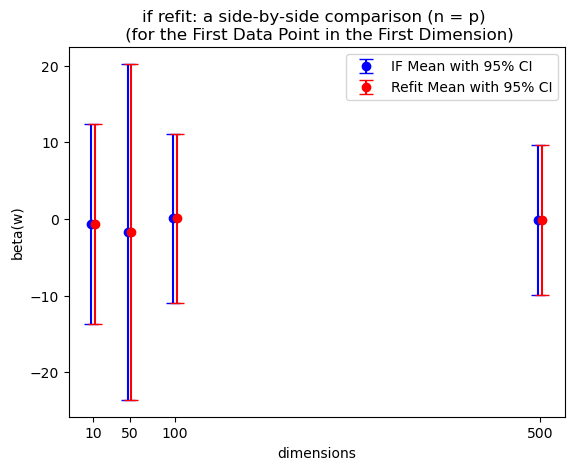

In [178]:
# create a plot for experiment 1.
experiment_1_data = pd.DataFrame(experiment_1_df[1:])

# Extracting p, mean, and standard deviation
dimensions = np.array(experiment_1_data['p'])
if_means = np.array(experiment_1_data['if_mean'])
if_sds = np.array(experiment_1_data['if_sd'])
refit_means = np.array(experiment_1_data['refit_mean'])
refit_sds = np.array(experiment_1_data['refit_sd'])

# Calculating confidence intervals (95% CI)
if_ci_lower = [mean - 1.96 * sd for mean, sd in zip(if_means, if_sds)]
if_ci_upper = [mean + 1.96 * sd for mean, sd in zip(if_means, if_sds)]
refit_ci_lower = [mean - 1.96 * sd for mean, sd in zip(refit_means, refit_sds)]
refit_ci_upper = [mean + 1.96 * sd for mean, sd in zip(refit_means, refit_sds)]

# Create offsets for side-by-side positioning
offset = 2.0
x_pos1 = dimensions - offset
x_pos2 = dimensions + offset

# Plotting
plt.errorbar(x_pos1, if_means, 
             yerr=[if_means - if_ci_lower, if_ci_upper - if_means], 
             fmt='o', capsize=5, label='IF Mean with 95% CI', color='blue')
plt.errorbar(x_pos2, refit_means, 
             yerr=[refit_means - refit_ci_lower, refit_ci_upper - refit_means], 
             fmt='o', capsize=5, label='Refit Mean with 95% CI', color='red')

# Labels and legend
plt.xticks(dimensions)
plt.xlabel('dimensions')
plt.ylabel('beta(w)')
plt.title('if refit: a side-by-side comparison (n = p) \n (for the First Data Point in the First Dimension)')
plt.legend()
# plt.savefig('plota.1.png')
plt.show()

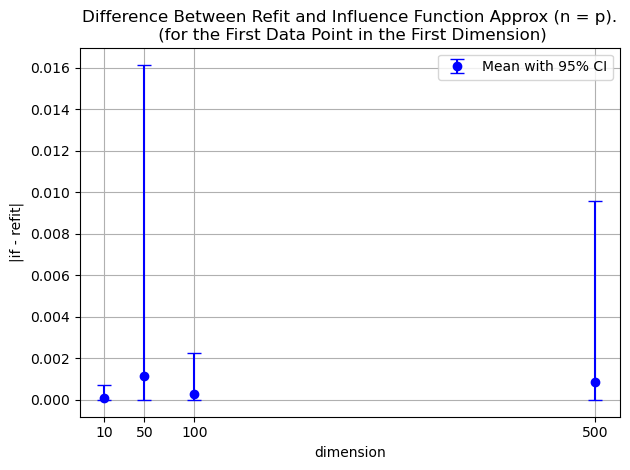

In [179]:
# create a plot for experiment 1.
experiment_1_data = pd.DataFrame(experiment_1_df[1:])

# Extracting p, mean, and standard deviation
dimension = np.array(experiment_1_data['p'])
diff_means = np.array(experiment_1_data['diff_mean'])
diff_sds = np.array(experiment_1_data['diff_sd'])
logdiff_means = np.array(experiment_1_data['log_diff_mean'])
logdiff_sds = np.array(experiment_1_data['log_diff_sd'])

# Calculating confidence intervals (95% CI)
ci_lower = [1.96 * sd for mean, sd in zip(diff_means, diff_sds)]
ci_upper = [1.96 * sd for mean, sd in zip(diff_means, diff_sds)]

# Calculate the error bars, ensuring the lower bound is not below zero
truncated_ci_lower = diff_means - ci_lower
for i in range(len(truncated_ci_lower)):
    if diff_means[i] - ci_lower[i] < 0:
        truncated_ci_lower[i] = diff_means[i]
# print("lower bounds: ", lower_bound)
# print("1.96sd: ", 1.96 * diff_sds)
# print("mean", diff_means)
# print('ci_upper:', ci_upper)

plt.errorbar(dimension, diff_means, yerr=[truncated_ci_lower, ci_upper], 
                 fmt='o', capsize=5, label='Mean with 95% CI', color='blue')

# labels
plt.title('Difference Between Refit and Influence Function Approx (n = p).\n (for the First Data Point in the First Dimension)')
plt.xlabel('dimension')
plt.ylabel('|if - refit|')
plt.xticks(dimension)  # Set x-ticks to dimension.
plt.grid(True)
plt.legend()
plt.tight_layout()
# Show plot
# plt.savefig('plotc.2.png')

plt.show()

# We now turn to the worst case |IF - Refit| Across all Data Points. 

In [180]:
# the |IF - refit| avg worst case error across data points and dimensions.
# average |IF - refit| across all simulations. pick out the worst case.
experiment_2 = []
for p in range(len(P_LIST)):
    diff_mean = np.mean([np.abs(ALL_SIMS[p]['results'][sim_num]['if'] -  ALL_SIMS[p]['results'][sim_num]['refit']) for sim_num in range(N_SIM)], axis=0) # computes the mean IF-Refit matrix (NxP).

    max_diff_mean = np.max(diff_mean)
    # find the index of the maximum difference.
    max_diff_index = np.argmax(diff_mean)
    max_index_2d = np.unravel_index(max_diff_index, diff_mean.shape)

    diff_sd = np.std([np.abs(ALL_SIMS[p]['results'][sim_num]['if'] - ALL_SIMS[p]['results'][sim_num]['refit']) for sim_num in range(N_SIM)], axis=0)
    max_diff_sd = diff_sd[max_index_2d[0]][max_index_2d[1]]

    # find the influence function and refit coefficients for the worst case.
    worst_case_if_mean = np.mean([ALL_SIMS[p]['results'][sim_num]['if'][max_index_2d[0]][max_index_2d[1]] for sim_num in range(N_SIM)], axis=0)
    worst_case_if_sd = np.std([ALL_SIMS[p]['results'][sim_num]['if'][max_index_2d[0]][max_index_2d[1]] for sim_num in range(N_SIM)], axis=0)
    worst_case_refit_mean = np.mean([ALL_SIMS[p]['results'][sim_num]['refit'][max_index_2d[0]][max_index_2d[1]] for sim_num in range(N_SIM)], axis=0)
    worst_case_refit_sd = np.std([ALL_SIMS[p]['results'][sim_num]['refit'][max_index_2d[0]][max_index_2d[1]] for sim_num in range(N_SIM)], axis=0)

    p_curr = {'p': P_LIST[p], 'max_diff_mean': max_diff_mean, 'max_diff_sd': max_diff_sd, 
              "worst_case_if_mean": worst_case_if_mean, "worst_case_if_sd": worst_case_if_sd, 
              "worst_case_refit_mean": worst_case_refit_mean, "worst_case_refit_sd": worst_case_refit_sd}
    experiment_2.append(p_curr)
    
experiment_2_df = pd.DataFrame(experiment_2)
print(experiment_2_df)

     p  max_diff_mean   max_diff_sd  worst_case_if_mean  worst_case_if_sd  \
0    1   6.810579e-08  1.845077e-07            1.072983         18.185225   
1   10   8.530387e-04  8.307238e-03            7.055635         70.743337   
2   50   1.489978e-02  1.328190e-01           -4.230992         35.822552   
3  100   1.171023e-03  7.074993e-03            1.245361          9.437838   
4  500   9.738582e-03  9.338910e-02           -1.156665         16.791086   

   worst_case_refit_mean  worst_case_refit_sd  
0               1.072983            18.185225  
1               7.056479            70.751622  
2              -4.245764            35.884380  
3               1.244441             9.434477  
4              -1.165933            16.882526  


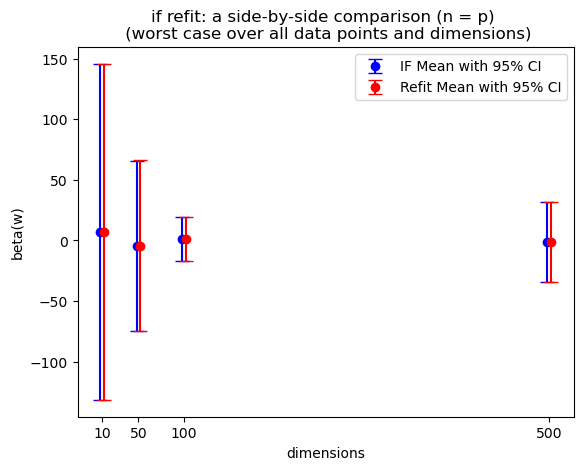

In [181]:
# create a plot for experiment 1.
experiment_2_data = pd.DataFrame(experiment_2_df[1:])

# Extracting p, mean, and standard deviation
dimensions = np.array(experiment_2_data['p'])
if_means = np.array(experiment_2_data['worst_case_if_mean'])
if_sds = np.array(experiment_2_data['worst_case_if_sd'])
refit_means = np.array(experiment_2_data['worst_case_refit_mean'])
refit_sds = np.array(experiment_2_data['worst_case_refit_sd'])

# Calculating confidence intervals (95% CI)
if_ci_lower = [mean - 1.96 * sd for mean, sd in zip(if_means, if_sds)]
if_ci_upper = [mean + 1.96 * sd for mean, sd in zip(if_means, if_sds)]
refit_ci_lower = [mean - 1.96 * sd for mean, sd in zip(refit_means, refit_sds)]
refit_ci_upper = [mean + 1.96 * sd for mean, sd in zip(refit_means, refit_sds)]

# Create offsets for side-by-side positioning
offset = 2.0
x_pos1 = dimensions - offset
x_pos2 = dimensions + offset

# Plotting
plt.errorbar(x_pos1, if_means, 
             yerr=[if_means - if_ci_lower, if_ci_upper - if_means], 
             fmt='o', capsize=5, label='IF Mean with 95% CI', color='blue')
plt.errorbar(x_pos2, refit_means, 
             yerr=[refit_means - refit_ci_lower, refit_ci_upper - refit_means], 
             fmt='o', capsize=5, label='Refit Mean with 95% CI', color='red')

# Labels and legend
plt.xticks(dimensions)
plt.xlabel('dimensions')
plt.ylabel('beta(w)')
plt.title('if refit: a side-by-side comparison (n = p) \n (worst case over all data points and dimensions)')
plt.legend()
# plt.savefig('plotd.1.png')

plt.show()

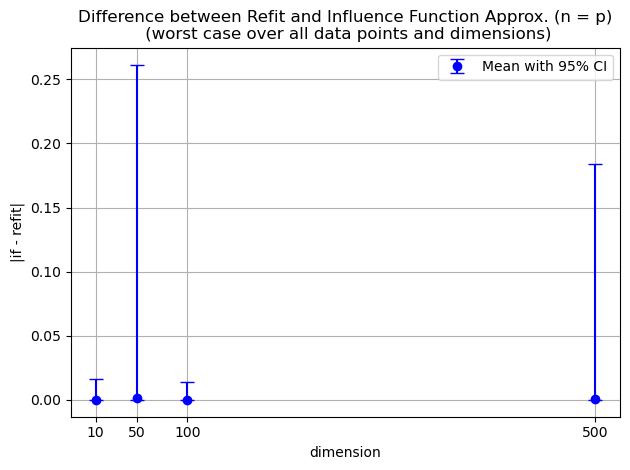

In [182]:
# create a plot for experiment 2.
experiment_2_data = pd.DataFrame(experiment_2_df[1:])

# Extracting p, mean, and standard deviation
dimension = np.array(experiment_2_data['p'])
max_diff_means = np.array(experiment_2_data['max_diff_mean'])
max_diff_sds = np.array(experiment_2_data['max_diff_sd'])

# Calculating confidence intervals (95% CI)
ci_lower = [1.96 * sd for mean, sd in zip(max_diff_means, max_diff_sds)]
ci_upper = [1.96 * sd for mean, sd in zip(max_diff_means, max_diff_sds)]

# Calculate the error bars, ensuring the lower bound is not below zero
truncated_ci_lower = diff_means - ci_lower
for i in range(len(truncated_ci_lower)):
    if diff_means[i] - ci_lower[i] < 0:
        truncated_ci_lower[i] = diff_means[i]

plt.errorbar(dimension, diff_means, yerr=[truncated_ci_lower, ci_upper], 
                 fmt='o', capsize=5, label='Mean with 95% CI', color='blue')

# Adding titles and labels
plt.title('Difference between Refit and Influence Function Approx. (n = p)\n (worst case over all data points and dimensions)')
plt.xlabel('dimension')
plt.ylabel('|if - refit|')
plt.xticks(dimension)  # Set x-ticks to dimension.
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('plotd.2.png')
# Show plot
plt.show()

In [65]:
# experiment_1_df.to_csv('experiment_1_oct24.csv', index=False)
# experiment_2_df.to_csv('experiment_2_oct24.csv', index=False)